## Linear Regression

### Added snippet used as a reference for all models

This model is based on the TuringTutorial example [LinearRegression](https://github.com/TuringLang/TuringTutorials/blob/csp/linear/LinearRegression.ipynb) by Cameron Pfiffer.

Turing is powerful when applied to complex hierarchical models, but it can also be put to task at common statistical procedures, like linear regression. This tutorial covers how to implement a linear regression model in Turing.

We begin by importing all the necessary libraries.

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, GLM
gr(size=(500,500))

ProjDir = rel_path("..", "scripts", "00")
cd(ProjDir)

Import the dataset.

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [3]:
data = filter(row -> row[:age] >= 18, df)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Show the first six rows of the dataset.

In [4]:
first(data, 6)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1


The next step is to get our data ready for testing. We'll split the mtcars dataset into two subsets, one for training our model and one for evaluating our model. Then, we separate the labels we want to learn (MPG, in this case) and standardize the datasets by subtracting each column's means and dividing by the standard deviation of that column.

The resulting data is not very familiar looking, but this standardization process helps the sampler converge far easier. We also create a function called unstandardize, which returns the standardized values to their original form. We will use this function later on when we make predictions.

Split our dataset 70%/30% into training/test sets.

In [5]:
n = size(data, 1)
test_ind = sample(1:n, Int(floor(0.3*n)), replace=false);
train_ind = [(i) for i=1:n if !(i in test_ind)];
test = data[test_ind, :];
train = data[train_ind, :];

Save dataframe versions of our dataset.

In [6]:
train_cut = DataFrame(train)
test_cut = DataFrame(test)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,168.275,54.6,41.0,1
2,144.145,33.906,34.0,0
3,156.21,41.0501,53.0,1
4,146.05,37.5064,53.0,0
5,151.765,44.3386,41.0,0
6,161.925,55.1114,30.0,1
7,147.32,48.9596,25.0,0
8,162.56,55.2815,46.0,1
9,139.7,50.3487,38.0,1


Create our labels. These are the values we are trying to predict.

In [7]:
train_label = train[:, :height]
test_label = test[:, :height]

105-element Array{Union{Missing, Float64},1}:
 168.275
 144.145
 156.21 
 146.05 
 151.765
 161.925
 147.32 
 162.56 
 139.7  
 170.815
   ⋮    
 145.415
 151.13 
 152.4  
 167.005
 142.24 
 161.3  
 151.13 
 161.29 
 148.59 

Get the list of columns to keep.

In [8]:
remove_names = filter(x->!in(x, [:height, :age, :male]), names(data))

1-element Array{Symbol,1}:
 :weight

Filter the test and train sets.

In [9]:
train = Matrix(train[:, remove_names]);
test = Matrix(test[:, remove_names]);

A handy helper function to rescale our dataset.

In [10]:
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

standardize (generic function with 1 method)

Another helper function to unstandardize our datasets.

In [11]:
function unstandardize(x, orig)
    return x .* std(orig, dims=1) .+ mean(orig, dims=1)
end

unstandardize (generic function with 1 method)

Standardize our dataset.

In [12]:
(train, train_orig) = standardize(train)
(test, test_orig) = standardize(test)
(train_label, train_l_orig) = standardize(train_label)
(test_label, test_l_orig) = standardize(test_label);

Design matrix

In [13]:
dmat = [ones(size(train, 1)) train]

247×2 Array{Float64,2}:
 1.0   0.436622
 1.0  -1.99302 
 1.0   1.23068 
 1.0   2.74543 
 1.0  -1.02203 
 1.0   1.60182 
 1.0  -1.53558 
 1.0   1.45077 
 1.0   0.751655
 1.0  -1.35864 
 ⋮             
 1.0  -1.04792 
 1.0  -0.128713
 1.0  -0.14166 
 1.0   0.445253
 1.0  -0.845091
 1.0  -0.629315
 1.0  -1.63052 
 1.0   1.0969  
 1.0   1.38604 

Bayesian linear regression.

In [14]:
lrmodel = "
data {
  int N; //the number of observations
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008

  y ~ normal(linpred,sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [15]:
stanmodel = Stanmodel(name="linear_regression",
  monitors = ["beta.1", "beta.2", "sigma"],
  model=lrmodel);
# Input data for cmdstan
lrdata = Dict("N" => size(train, 1), "K" => size(dmat, 2), "y" => train_label, "X" => dmat);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/00/tmp/linear_regression.stan will be updated.



Sample using cmdstan

In [16]:
rc, sim, cnames = stan(stanmodel, lrdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Convert to a MCMCChain Chain object
cnames = ["intercept", "beta[1]", "sigma"]
chain = convert_a3d(sim, cnames, Val(:mcmcchain))

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -51.9374, but must be > 0!  (in '/Users/rob/.julia/dev/StatisticalRethinking/scripts/00/tmp/linear_regression.stan' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -54.6292, but must be > 0!  (in '/Users/rob/.julia/dev/StatisticalRethinking/scripts/00/tmp/linear_regression.stan' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be ei

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[0.0138265 0.818786 0.682115; 0.000730265 0.808917 0.611278; … ; -0.0388617 0.757684 0.642268; -0.0049621 0.778774 0.635562]

Union{Missing, Float64}[0.00116312 0.730363 0.588596; -0.0345352 0.81347 0.650014; … ; -0.0108046 0.77821 0.704372; 0.00800733 0.900795 0.60848]

Union{Missing, Float64}[0.0614467 0.847175 0.634238; 0.0217511 0.865627 0.621396; … ; 0.0185883 0.733703 0.658121; 0.0395843 0.743631 0.604554]

Union{Missing, Float64}[0.00971935 0.818372 0.682005; 0.0222517 0.733377 0.60054; … ; 0.0297603 0.813666 0.629159; 0.00203633 0.717082 0.645181]

Describe the chains.

In [17]:
describe(chain)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
               Mean           SD        Naive SE        MCSE      ESS
intercept -0.00013343667 0.040759985 0.00064447196 0.00065464463 1000
  beta[1]  0.77127356475 0.040264052 0.00063663057 0.00079847759 1000
    sigma  0.63945972500 0.028648342 0.00045297005 0.00046143857 1000

Quantiles:
              2.5%       25.0%       50.0%       75.0%      97.5%  
intercept -0.07963015 -0.0282806 0.0001654085 0.02646255 0.08262662
  beta[1]  0.69350763  0.7445275 0.7711020000 0.79817350 0.84985118
    sigma  0.58790155  0.6187655 0.6388235000 0.65848675 0.69716797



Perform multivariate OLS.

In [18]:
ols = lm(@formula(height ~ weight), train_cut)

StatsModels.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: height ~ 1 + weight

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)   113.514   2.17449 52.2024   <1e-99
weight       0.910724 0.0478616 19.0283   <1e-49


Store our predictions in the original dataframe.

In [19]:
train_cut.OLSPrediction = predict(ols);
test_cut.OLSPrediction = predict(ols, test_cut);

Make a prediction given an input vector.

In [20]:
function prediction(chain, x)
    α = chain[:, 1, :].value
    β = [chain[:, i, :].value for i in 2:2]
    return  mean(α) .+ x * mean.(β)
end

prediction (generic function with 1 method)

Calculate the predictions for the training and testing sets.

In [21]:
train_cut.BayesPredictions = unstandardize(prediction(chain, train), train_l_orig);
test_cut.BayesPredictions = unstandardize(prediction(chain, test), test_l_orig);

Show the first side rows of the modified dataframe.

In [22]:
remove_names = filter(x->!in(x, [:age, :male]), names(test_cut));
test_cut = test_cut[remove_names];
first(test_cut, 6)

bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.height).^2);
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.height).^2);

bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.height).^2);
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.height).^2);

println("\nTraining set:")
println("  Bayes loss: $bayes_loss1")
println("  OLS loss: $ols_loss1")

println("Test set:")
println("  Bayes loss: $bayes_loss2")
println("  OLS loss: $ols_loss2")


Training set:
  Bayes loss: 5957.9723107475265
  OLS loss: 5957.9569077640435
Test set:
  Bayes loss: 3107.358748281501
  OLS loss: 3101.5364539074017


Plot the chains.

┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/UQI78/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ 

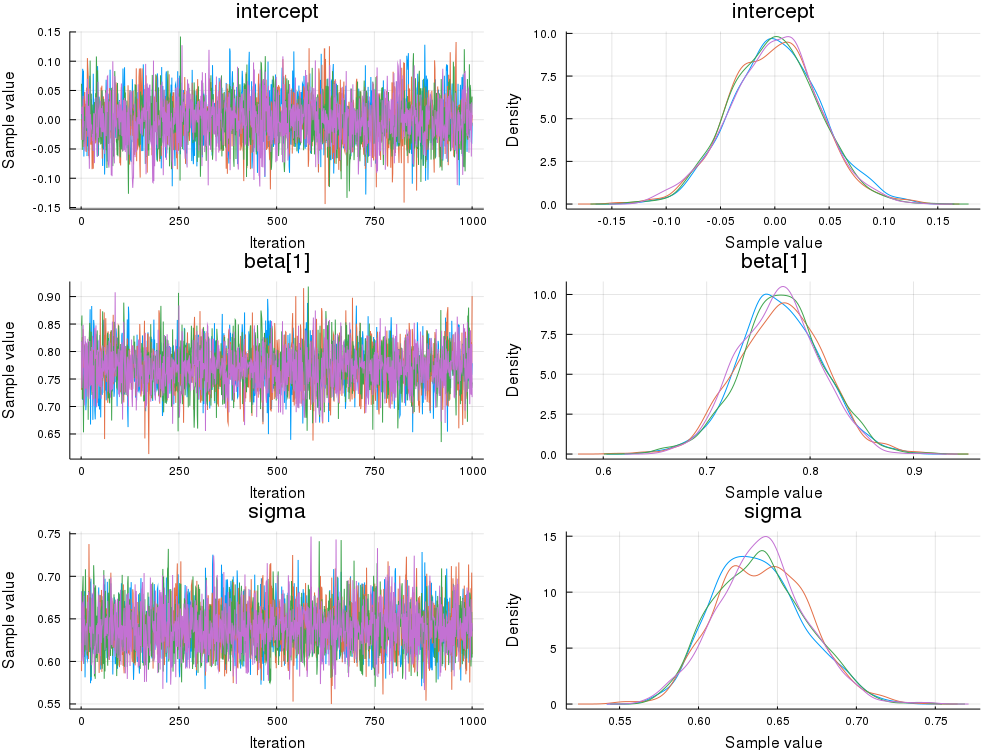

In [23]:
plot(chain)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*